In [1]:
import pandas as pd
from datetime import datetime
import gdal
import numpy as np
import subprocess
import glob
# from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from dateutil.parser import parse
from collections import Counter

In [2]:
train_labels = pd.read_csv("train_labels.csv")
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')
test_labels = pd.read_csv("submission_format.csv")

In [3]:
train_labels["datetime_dt"]= pd.to_datetime(train_labels["datetime"])

In [4]:
train_labels.groupby("grid_id").size().sort_values(ascending=False).head()

grid_id
3S31A    1047
PG3MI    1042
E5P9N    1040
ZZ8JF    1038
QJHW4    1036
dtype: int64

<AxesSubplot:>

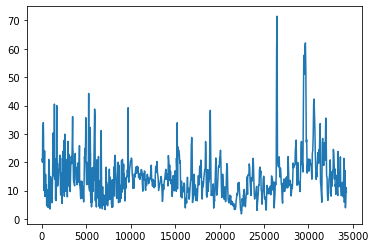

In [5]:
train_labels[train_labels["grid_id"]=="PG3MI"]["value"].plot()

In [6]:
train_labels

,datetime,grid_id,value,datetime_dt
0,2018-02-01T08:00:00Z,3S31A,11.400000,2018-02-01 08:00:00+00:00
1,2018-02-01T08:00:00Z,A2FBI,17.000000,2018-02-01 08:00:00+00:00
2,2018-02-01T08:00:00Z,DJN0F,11.100000,2018-02-01 08:00:00+00:00
3,2018-02-01T08:00:00Z,E5P9N,22.100000,2018-02-01 08:00:00+00:00
4,2018-02-01T08:00:00Z,FRITQ,29.800000,2018-02-01 08:00:00+00:00
...,...,...,...,...
34307,2020-12-31T18:30:00Z,P8JA5,368.611111,2020-12-31 18:30:00+00:00
34308,2020-12-31T18:30:00Z,PW0JT,294.425000,2020-12-31 18:30:00+00:00
34309,2020-12-31T18:30:00Z,VXNN3,224.857143,2020-12-31 18:30:00+00:00
34310,2020-12-31T18:30:00Z,VYH7U,287.000000,2020-12-31 18:30:00+00:00


In [7]:
satellite_metadata.head()

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
0,20180201T191000_maiac_la_0.hdf,2018-02-01T17:25:00.000Z,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736,2018-02-01 19:10:00+00:00
1,20180202T195000_maiac_la_0.hdf,2018-02-02T18:05:00.000Z,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180,2018-02-02 19:50:00+00:00
2,20180203T203000_maiac_la_0.hdf,2018-02-03T17:10:00.000Z,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482,2018-02-03 20:30:00+00:00
3,20180204T194000_maiac_la_0.hdf,2018-02-04T17:55:00.000Z,2018-02-04 19:40:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4105997844,13064424,2018-02-04 19:40:00+00:00
4,20180205T202000_maiac_la_0.hdf,2018-02-05T17:00:00.000Z,2018-02-05 20:20:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1805072340,12549313,2018-02-05 20:20:00+00:00


In [8]:
import glob
len(glob.glob("train/maiac/*/*.hdf"))


all_files= glob.glob("train/maiac/*/*.hdf")

In [9]:
all_data = []
def get_all_data_for_loci(ds,granule_id,parellel = False):
    each = {}
    metadata = ds.GetMetadata()
    for i in range(len(ds.GetSubDatasets())):
        raster = gdal.Open(ds.GetSubDatasets()[i][0]) #grid5km:cosSZA features only
        each_raster = raster.GetMetadata()

        long_name = each_raster["long_name"]

         
        all_rasters = []
        if(parellel):
            listi = list(range(int(raster.GetMetadata()["ADDITIONALLAYERS"])))
            
            N = pool.imap(partial(rast_each_info, rasteri=raster), listi)
            
            print(N)
        else:
            for j in range(int(raster.GetMetadata()["ADDITIONALLAYERS"])):
                try:
                    band = raster.GetRasterBand(j+1)
                    band_arr = band.ReadAsArray()
                    all_rasters.append(band_arr.tolist())
                except:
                    pass
            each[long_name] = all_rasters
    
    each_data_f = {'file':granule_id,'data':each}
    return each_data_f
    

In [10]:
def get_all_data_for_loci_specific(ds,granule_id,parellel = False):
    each = {}
    s = ds.GetSubDatasets()
    raster = gdal.Open(s[8][0]) #grid5km:cosSZA features only
    each_raster = raster.GetMetadata()
    long_name = each_raster["long_name"]

    all_rasters = []
    if(parellel):
        listi = list(range(int(raster.GetMetadata()["ADDITIONALLAYERS"])))

        N = pool.imap(partial(rast_each_info, rasteri=raster), listi)

        print(N)
    else:
        for j in range(int(raster.GetMetadata()["ADDITIONALLAYERS"])):
            try:
                band = raster.GetRasterBand(j+1)
                band_arr = band.ReadAsArray()
                all_rasters.append(band_arr)
            except:
                pass
        each[long_name] = all_rasters
        
    raster = gdal.Open(s[7][0]) #grid5km:cosSZA features only
    each_raster = raster.GetMetadata()
    long_name = each_raster["long_name"]
    all_rasters2 = []
    if(parellel):
        listi = list(range(int(raster.GetMetadata()["ADDITIONALLAYERS"])))

        N = pool.imap(partial(rast_each_info, rasteri=raster), listi)

        print(N)
    else:
        for j in range(int(raster.GetMetadata()["ADDITIONALLAYERS"])):
            try:
                band = raster.GetRasterBand(j+1)
                band_arr = band.ReadAsArray()
                all_rasters2.append(band_arr)
            except:
                pass
        each[long_name] = all_rasters2

    each_data_f = {'file':granule_id,'data':each}
    del ds
    return each_data_f

In [11]:
# import pprofile
# profiler = pprofile.Profile()
# with profiler:
#     fetch_subset('20180308T031500_maiac_tpe_0.hdf')
# # Process profile content: generate a cachegrind file and send it to user.

# # You can also write the result to the console:
# profiler.print_stats()

In [12]:
# Opens the HDF file
def load_data(FILEPATH):
    ds = gdal.Open(FILEPATH)
    return ds

def format_file_path(granule_id):
    year = granule_id[:4]
    res = 'train/maiac/'+year+'/'+granule_id
    return res

def fetch_subset(granule_id):
    formatted = format_file_path(granule_id)
    ds = load_data( formatted)
    return get_all_data_for_loci(ds,granule_id)

In [13]:
granule_id = '20180308T031500_maiac_tpe_0.hdf'
formatted = format_file_path(granule_id)
ds = load_data( formatted)

In [14]:
raster = gdal.Open(ds.GetSubDatasets()[0][0]) #grid5km:cosSZA features only
each_raster = raster.GetMetadata()

long_name = each_raster["long_name"]

In [315]:
# import pprofile
# profiler = pprofile.Profile()
# with profiler:
#     get_all_data_for_loci_specific(ds,granule_id)
# # Process profile content: generate a cachegrind file and send it to user.

# # You can also write the result to the console:
# profiler.print_stats()

In [316]:
%%time
res = fetch_subset('20180308T031500_maiac_tpe_0.hdf')

CPU times: user 1.94 s, sys: 359 ms, total: 2.3 s
Wall time: 2.3 s


In [317]:
res["data"].keys()

dict_keys(['AOD at 0.47 micron', 'AOD at 0.55 micron', 'AOD uncertainty at 0.47 micron, range 0-4', 'Fine mode fraction for Ocean', 'Column Water Vapor (in cm liquid water)', 'AOD_QA', 'Regional background model used', 'Smoke Injection Height over local surface height, in meters', 'cosine of Solar Zenith Angle', 'cosine of View Zenith Angle', 'Relative Azimuth Angle', 'Scattering Angle', 'Glint Angle'])

In [318]:
# dir(res["data"]['AOD at 0.47 micron'][0].ReadRaster())()

In [319]:
def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

In [320]:
def fetch_satellite_meta(metadata, datetime, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"
    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parse(datetime)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

In [321]:
def fetch_training_features(grid_id, datetime, split):
    temp = get_grid_data(grid_metadata, grid_id)
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               datetime, 
                               temp.iloc[0]['location'], 
                               "maiac", 
                               split)
    counter = 0
    features = None
    for i in range(len(sat_met)):
        counter+=1
        granule_id = sat_met.iloc[i]['granule_id']

        subset = fetch_subset(granule_id)
        if features is None:
            features = subset
        else:
            features+=subset
    return features/counter

In [322]:
def fetch_training_features(grid_id, datetime, split):
    temp = get_grid_data(grid_metadata, grid_id)
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               datetime, 
                               temp.iloc[0]['location'], 
                               "maiac", 
                               split)
    counter = 0
    features = None
    granule_id_loc = []
    for i in range(len(sat_met)):
        counter+=1
        granule_id = sat_met.iloc[i]['granule_id']
        granule_id_loc.append(granule_id)
    return granule_id_loc
        
#         subset = fetch_subset(granule_id)
        

In [323]:
from multiprocessing import Pool
import tqdm

# features = []
split = "train"
# pool = Pool(processes=16)


In [324]:
tasks = list(zip(train_labels["grid_id"],train_labels["datetime"]))
tasks[:5]

[('3S31A', '2018-02-01T08:00:00Z'),
 ('A2FBI', '2018-02-01T08:00:00Z'),
 ('DJN0F', '2018-02-01T08:00:00Z'),
 ('E5P9N', '2018-02-01T08:00:00Z'),
 ('FRITQ', '2018-02-01T08:00:00Z')]

In [305]:
len(tasks)

34312

In [306]:
def get_ds_loc(i):
    feature = fetch_training_features(i[0], i[1], split)
    return feature

In [307]:
get_ds_loc(tasks[5])

['20180201T191000_maiac_la_0.hdf']

In [28]:
from multiprocessing import get_context

# pool = get_context("fork").Pool()
pool = Pool(processes=8)

all_files_d = []
for x in tqdm.tqdm(pool.imap_unordered(get_ds_loc, tasks), total=len(tasks)):
    all_files_d.append(x)

100% 34312/34312 [00:17<00:00, 2010.89it/s]


In [29]:
# all_files_d

In [30]:
len(all_files_d)

34312

In [31]:
all_files_d[0]

['20180201T191000_maiac_la_0.hdf']

In [32]:
# del j
# gc.collect()

In [33]:
all_files_d[0]

['20180201T191000_maiac_la_0.hdf']

In [34]:
data_to_loc = {"|".join(i):j for i,j in zip(tasks,all_files_d)}

In [35]:
all_files_flatten = [j for i in all_files_d for j in i ]

In [36]:
all_files_flatten = list(set(all_files_flatten))

In [37]:
len(all_files_flatten)

4234

In [38]:
def get_ds_loc(i):
    feature = fetch_training_features(i[0], i[1], split)
    print(i)
    return feature

In [39]:
get_ds_loc(tasks[5])

('H96P6', '2018-02-01T08:00:00Z')


['20180201T191000_maiac_la_0.hdf']

In [40]:
%%time
res = fetch_subset('20180308T031500_maiac_tpe_0.hdf')

CPU times: user 124 ms, sys: 17.1 ms, total: 142 ms
Wall time: 139 ms


In [42]:
res["data"].keys()

dict_keys(['cosine of Solar Zenith Angle', 'Smoke Injection Height over local surface height, in meters'])

In [43]:
from multiprocessing import get_context

# pool = get_context("fork").Pool()
pool = Pool(processes=100)

all_files_d_100 = []
for x in tqdm.tqdm(pool.imap_unordered(fetch_subset, all_files_flatten), total=len(all_files_flatten)):
    all_files_d_100.append(x)

  0% 0/4234 [00:00<?, ?it/s]ERROR 5: HDF4_EOS:EOS_GRID:"train/maiac/2018/20181106T070000_maiac_dl_0.hdf":grid5km:cosSZA: GDALDataset::GetRasterBand(4) - Illegal band #

ERROR 5: HDF4_EOS:EOS_GRID:"train/maiac/2020/20200826T023500_maiac_tpe_0.hdf":grid5km:cosSZA: GDALDataset::GetRasterBand(3) - Illegal band #

ERROR 5: HDF4_EOS:EOS_GRID:"train/maiac/2020/20200826T023500_maiac_tpe_0.hdf":grid5km:cosSZA: GDALDataset::GetRasterBand(4) - Illegal band #

ERROR 5: HDF4_EOS:EOS_GRID:"train/maiac/2018/20180406T191000_maiac_la_0.hdf":grid5km:cosSZA: GDALDataset::GetRasterBand(5) - Illegal band #

ERROR 5: HDF4_EOS:EOS_GRID:"train/maiac/2020/20200308T192000_maiac_la_0.hdf":grid5km:cosSZA: GDALDataset::GetRasterBand(5) - Illegal band #

ERROR 5: HDF4_EOS:EOS_GRID:"train/maiac/2018/20180810T025500_maiac_tpe_1.hdf":grid5km:cosSZA: GDALDataset::GetRasterBand(4) - Illegal band #

ERROR 5: HDF4_EOS:EOS_GRID:"train/maiac/2018/20180405T034000_maiac_tpe_1.hdf":grid5km:cosSZA: GDALDataset::GetRasterBand(5)

In [49]:
res["data"].keys()



dict_keys(['cosine of Solar Zenith Angle', 'Smoke Injection Height over local surface height, in meters'])

In [45]:
# from multiprocessing import get_context
# p = get_context("fork").Pool(8)
# all_files_d_100 = []
# for i in tqdm.tqdm(all_files_flatten):
#     x = fetch_subset(i)
#     all_files_d_100.append(x)

In [46]:
all_files_d_100_dict= {i["file"]:i["data"] for i in all_files_d_100 }

In [47]:
import gc
del all_files_d_100
gc.collect()

0

In [50]:
all_47 = []
all_55 = []
# 'AOD at 0.55 micron'
for i in all_files_d_100_dict.values():
    for j in i['cosine of Solar Zenith Angle']:
        all_47.append(j)
    for j in i['Smoke Injection Height over local surface height, in meters']:
        all_55.append(j)
        

In [51]:
# l=[]
# for i in all_files_d_100[:100]:
#     for j in i["data"].values():
#         for img in j:
#             img = np.where(img <0 , 0, img)
#             l.append((np.count_nonzero(img)/(1200*1200)))

In [52]:
# sum(l)/len(l)

In [53]:
len(all_files_d_100_dict)

4234

In [54]:
data_to_loc['3S31A|2018-02-01T08:00:00Z']

['20180201T191000_maiac_la_0.hdf']

In [55]:
# 3S31A

In [56]:
data_to_y = {}

In [57]:
# [all_files_d_100_dict[data_to_loc[i[1]+"|"+i[0]][0]],j]

In [58]:
all_files_flatten[0]

'20200109T193500_maiac_la_0.hdf'

In [59]:
dt = []
loc = []
for i in train_labels.values:
    try:
        dt.append( [all_files_d_100_dict[data_to_loc[i[1]+"|"+i[0]][0]],i[2]] )
        loc.append(i[1])
    except:
        pass


In [60]:
# dt[0]

In [61]:
# loc

In [62]:
x = []
for each in dt:
    x.append([i for j in each[0].values() for i in j[:3]])

In [63]:
# x[0]|

In [64]:
# x = [np.array(i) for i in x]

In [65]:
y = [ i[1] for i in dt]

In [66]:
del dt

In [67]:
import gc
gc.collect()

0

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore')
# x_one = enc.fit_transform(np.array(loc).reshape(-1, 1)).toarray()
# del x_one

In [70]:
# for i in train_test_split(x, y,loc, test_size=0.2, random_state=1):
#     print(i[0])

In [71]:
# gc.collect()

In [72]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 


In [73]:
# print(X_train[0].max())

In [74]:
# max([i.max() for i in x])

In [75]:
batch_size = 128
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [76]:
print(f"Train Data: {len(X_train)}")
print(f"Validation Data: {len(X_val)}")
print(f"Test Data: {len(X_test)}")

Train Data: 20586
Validation Data: 6863
Test Data: 6863


In [77]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F

In [78]:
# from .types_ import *
from torch import nn

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input) :
        raise NotImplementedError

    def decode(self, input):
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) :
        raise NotImplementedError

    def generate(self, x, **kwargs) :
        raise NotImplementedError

#     @abstractmethod
    def forward(self, *inputs) :
        pass

#     @abstractmethod
    def loss_function(self, *inputs, **kwargs) :
        pass

In [242]:
config = {'model_params':
  {'name': 'BetaVAE',
  'in_channels': 1,
  'latent_dim': 128,
  'loss_type': 'B',
  'gamma': 10.0,
  'max_capacity': 25,
  'Capacity_max_iter': 10000},

'data_params':
  {'data_path': "Data/",
  'train_batch_size': 128,
  'val_batch_size':  128,
  'patch_size': 64,
  'num_workers': 4},
  
'exp_params':
  {'LR': 0.005,
  'weight_decay': 0.0,
  'scheduler_gamma': 0.95,
  'kld_weight': 0.00025,
  'manual_seed': 1265},

'trainer_params':
  {
      'gpus': [0],
  'max_epochs': 3
  },

'logging_params':{
    'save_dir': "logs/",
  'manual_seed': 1265,
  'name': 'BetaVAE'
}
  
}

In [243]:
import os
import torch
from torch import Tensor
from pathlib import Path
from typing import List, Optional, Sequence, Union, Any, Callable
from torchvision.datasets.folder import default_loader
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CelebA
import zipfile

In [244]:
# all_47 = []
# all_55 = []

In [245]:
len(all_55)

15268

In [246]:
class SatelliteDataset_XONLY(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
#         self.y_list = y_list

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img = self.file_list[idx]
        img = np.where(img <0 , 0, img)/9940
        img_transformed = self.transform(img)
        
        return img_transformed.float() , 0.0

In [247]:
# all_47[0]

In [248]:
train_transforms = transforms.Compose([
                                              transforms.ToTensor(),transforms.Resize(1024),])

In [249]:
check = SatelliteDataset_XONLY(all_47,train_transforms)

In [250]:
max([i.max() for i in all_47])

9940

In [251]:
img = check[2][0]

In [252]:
np.where(img <0 , 0, img).max()

0.6297787

In [253]:
check[0][0].shape

torch.Size([1, 1024, 1024])

In [254]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split( all_47, test_size=0.20, random_state=42)

In [255]:
# 1+1

In [256]:
# all_47[0:100]

In [257]:
# import pickle
# with open('file.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(all_47, file)

In [258]:
# with open('file2.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(all_55, file)

In [259]:
# all_47_flat = [ i.flatten() for i in all_47]

In [260]:
# del all_47_flat

In [261]:
# for i i

In [262]:
# for i in range(1200)


# -28672

In [263]:

class VAEDataset(LightningDataModule):
    """
    PyTorch Lightning data module 
    Args:
        data_dir: root directory of your dataset.
        train_batch_size: the batch size to use during training.
        val_batch_size: the batch size to use during validation.
        patch_size: the size of the crop to take from the original images.
        num_workers: the number of parallel workers to create to load data
            items (see PyTorch's Dataloader documentation for more details).
        pin_memory: whether prepared items should be loaded into pinned memory
            or not. This can improve performance on GPUs.
    """

    def __init__(
        self,
        data_path: str,
        train_batch_size: int = 8,
        val_batch_size: int = 8,
        patch_size: Union[int, Sequence[int]] = (256, 256),
        num_workers: int = 0,
        pin_memory: bool = False,
        **kwargs,
    ):
        super().__init__()

        self.data_dir = data_path
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

    def setup(self, stage: Optional[str] = None) -> None:
#       =========================  OxfordPets Dataset  =========================
            
#         train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                               transforms.CenterCrop(self.patch_size),
# #                                               transforms.Resize(self.patch_size),
#                                               transforms.ToTensor(),
#                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
#         val_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
#                                             transforms.CenterCrop(self.patch_size),
# #                                             transforms.Resize(self.patch_size),
#                                             transforms.ToTensor(),
#                                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#         self.train_dataset = OxfordPets(
#             self.data_dir,
#             split='train',
#             transform=train_transforms,
#         )
        
#         self.val_dataset = OxfordPets(
#             self.data_dir,
#             split='val',
#             transform=val_transforms,
#         )
        
#       =========================  CelebA Dataset  =========================
    
        train_transforms = transforms.Compose([
                                              transforms.ToTensor(),
                                                transforms.Resize(1024),])
        
        val_transforms = transforms.Compose([
                                              transforms.ToTensor(),
                                                transforms.Resize(1024),])
        
        self.train_dataset = SatelliteDataset_XONLY(
            X_train,
            transform=train_transforms,
        )
        
        # Replace CelebA with your dataset
        self.val_dataset = SatelliteDataset_XONLY(
            X_val,
            transform=val_transforms
        )
#       ===============================================================
        
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=self.pin_memory,
        )
    
    def test_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=144,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

In [264]:
data = VAEDataset(**config["data_params"], pin_memory=len(config['trainer_params']['gpus']) != 0)
data.setup()

In [265]:
import os
import yaml
import argparse
import numpy as np
from pathlib import Path

import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from pytorch_lightning.plugins import DDPPlugin

tb_logger =  TensorBoardLogger(save_dir=config['logging_params']['save_dir'],
                               name=config['model_params']['name'],)
runner = Trainer(logger=tb_logger,
                 callbacks=[
                     LearningRateMonitor(),
                     ModelCheckpoint(save_top_k=2, 
                                     dirpath =os.path.join(tb_logger.log_dir , "checkpoints"), 
                                     monitor= "val_loss",
                                     save_last= True),
                 ],
                 strategy=DDPPlugin(find_unused_parameters=False),
                 **config['trainer_params'])


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [266]:
from typing import List
from torch.nn import functional as F
class BetaVAE(BaseVAE):

    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 beta: int = 4,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 Capacity_max_iter: int = 1e5,
                 loss_type:str = 'B',
                 **kwargs) -> None:
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter

        modules = []
        if hidden_dims is None:
            hidden_dims = [2,4,8,16,32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_var = nn.Linear(2048, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 1,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z) :
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar) :
        """
        Will a single z be enough ti compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        self.num_iter += 1
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

        recons_loss =F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) :
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs) :
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]
model = BetaVAE(**config['model_params'])

In [267]:
# all_55[0]

# check[0][0].unsqueeze(0)

In [268]:
vali = check[10][0]
vali.dtype

torch.float32

In [285]:
res, res1 , compres, compress_log = model(vali.unsqueeze(0))

In [286]:
# res.cpu().numpy()

In [287]:
from sklearn.metrics import mean_squared_error

In [288]:
mean_squared_error(res.cpu().detach().numpy().flatten(), res1.cpu().detach().numpy().flatten())

0.09260122

In [273]:
# 0.16394849
# torch.save(model, "./aodqa.pth") 

In [274]:
# model = BetaVAE(**config['model_params'])

In [275]:
train_dataloader = data.train_dataloader()
val_dataloader = data.val_dataloader()

In [276]:

   
import os
import math
import torch
from torch import optim

import pytorch_lightning as pl
from torchvision import transforms
import torchvision.utils as vutils
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader

class VAEXperiment(pl.LightningModule):

    def __init__(self,
                 vae_model: BaseVAE,
                 params: dict) -> None:
        super(VAEXperiment, self).__init__()

        self.model = vae_model
        self.params = params
        self.curr_device = None
        self.hold_graph = False
        try:
            self.hold_graph = self.params['retain_first_backpass']
        except:
            pass

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        return self.model(input, **kwargs)

    def training_step(self, batch, batch_idx, optimizer_idx = 0):
        real_img, labels = batch
        self.curr_device = real_img.device

        results = self.forward(real_img, labels = labels)
        train_loss = self.model.loss_function(*results,
                                              M_N = self.params['kld_weight'], #al_img.shape[0]/ self.num_train_imgs,
                                              optimizer_idx=optimizer_idx,
                                              batch_idx = batch_idx)

        self.log_dict({key: val.item() for key, val in train_loss.items()}, sync_dist=True)

        return train_loss['loss']

    def validation_step(self, batch, batch_idx, optimizer_idx = 0):
        real_img, labels = batch
        self.curr_device = real_img.device

        results = self.forward(real_img, labels = labels)
        val_loss = self.model.loss_function(*results,
                                            M_N = 1.0, #real_img.shape[0]/ self.num_val_imgs,
                                            optimizer_idx = optimizer_idx,
                                            batch_idx = batch_idx)

        self.log_dict({f"val_{key}": val.item() for key, val in val_loss.items()}, sync_dist=True)

        
    def on_validation_end(self) -> None:
        self.sample_images()
        
    def sample_images(self):
        # Get sample reconstruction image            
        test_input, test_label = next(iter(self.trainer.datamodule.test_dataloader()))
        test_input = test_input.to(self.curr_device)
        test_label = test_label.to(self.curr_device)

#         test_input, test_label = batch
        recons = self.model.generate(test_input, labels = test_label)

    

    def configure_optimizers(self):

        optims = []
        scheds = []

        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.params['LR'],
                               weight_decay=self.params['weight_decay'])
        optims.append(optimizer)
        # Check if more than 1 optimizer is required (Used for adversarial training)
        try:
            if self.params['LR_2'] is not None:
                optimizer2 = optim.Adam(getattr(self.model,self.params['submodel']).parameters(),
                                        lr=self.params['LR_2'])
                optims.append(optimizer2)
        except:
            pass

        try:
            if self.params['scheduler_gamma'] is not None:
                scheduler = optim.lr_scheduler.ExponentialLR(optims[0],
                                                             gamma = self.params['scheduler_gamma'])
                scheds.append(scheduler)

                # Check if another scheduler is required for the second optimizer
                try:
                    if self.params['scheduler_gamma_2'] is not None:
                        scheduler2 = optim.lr_scheduler.ExponentialLR(optims[1],
                                                                      gamma = self.params['scheduler_gamma_2'])
                        scheds.append(scheduler2)
                except:
                    pass
                return optims, scheds
        except:
            return optims

In [277]:
experiment = VAEXperiment(model,
                          config['exp_params'])

In [284]:
runner.fit(experiment, datamodule=data)

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | BetaVAE | 3.9 M 
----------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.756    Total estimated model params size (MB)
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /workspace/logs/BetaVAE/version_11/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [ ]:
res, res1 , compres, compress_log = model(vali.unsqueeze(0))

In [289]:
torch.save(model, "./cosine.pth")

In [175]:
from operator import itemgetter

from pympler import tracker

mem = tracker.SummaryTracker()
print(sorted(mem.create_summary(), reverse=True, key=itemgetter(2))[:10])


[['numpy.ndarray', 31153, 87992813545], ['str', 346199, 45607491], ['dict', 88245, 30717296], ['list', 136273, 19365248], ['pandas.core.series.Series', 50, 14481385], ['pandas.core.frame.DataFrame', 12, 14475855], ['tuple', 184438, 11318624], ['code', 53245, 9506808], ['type', 7958, 7522920], ['int', 205338, 5794420]]


In [183]:
def lsos(n=10):

    import pandas as pd
    import sys

    all_obj =globals()

    object_name = list(all_obj).copy()
    object_size = [sys.getsizeof(all_obj[x]) for x in object_name]

    d = pd.DataFrame(dict(name = object_name, size = object_size))
    d.sort_values(['size'], ascending=[0],inplace=True)

    return(d.head(n))


In [184]:
lsos(n=10)

,name,size
33,satellite_metadata,7137213
41,_6,5318504
117,j,2880120
119,img,2880120
34,test_labels,1985232
94,data_to_loc,1310808
76,tasks,304568
158,loc,285376
88,x,285376
166,y,285376


In [182]:
# all_obj =globals()
# all_obj

In [176]:
# del train_labels

In [208]:
# 739328/1200

In [101]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [102]:
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)


In [86]:
class SatelliteDataset(Dataset):
    def __init__(self, file_list, y_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.y_list = y_list

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img = np.array(self.file_list[idx])
        img = np.where(img <0 , 0, img)/4089
        img_transformed = self.transform(img)


        label = self.y_list[idx]
        img_transformed= img_transformed.reshape((6, 1200, 1200))
        return img_transformed, label

In [87]:
train_data = SatelliteDataset(X_train, y_train, transform=train_transforms)
valid_data = SatelliteDataset(X_val, y_val, transform=test_transforms)
test_data = SatelliteDataset(X_test, y_test, transform=test_transforms)

In [88]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)


In [198]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim+54),
            nn.Linear(dim+54, 512),
              nn.LeakyReLU(),
            nn.Linear(512, 256),
              nn.LeakyReLU(),
              nn.Linear(256, 32),
            nn.LeakyReLU(),
              nn.Linear(32, 16),
            nn.LeakyReLU(),
              nn.Linear(16, 1),
        )

    def forward(self, img,one_hot):

        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        x = torch.cat((x, one_hot), dim=1)
        x = self.mlp_head(x)
        return x

In [199]:
import torch
# from vit_pytorch import ViT

v = ViT(
    image_size = 1200,
    patch_size = 50,
    num_classes = 1,
    channels = 6,
    dim = 1024,
    depth = 3,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.2,
    emb_dropout = 0.1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(v.parameters(), lr=1e-4)



In [200]:
torch.cuda.empty_cache()

In [201]:
img = torch.randn(1, 6, 1200, 1200).float()
img.dtype

torch.float32

In [234]:
one_hot_example = torch.from_numpy(loc_val[0:8]).float()

In [235]:
one_hot_example.shape

torch.Size([8, 54])

In [204]:
one_hot_example.shape

torch.Size([1, 54])

In [ ]:
for i, data in enumerate(valid_loader, 0):
    print(data)
    break

In [259]:
# [ i[0] for i in valid_data[:32]]

l = []
for i in valid_data:
    l.append(i[0])

KeyboardInterrupt: 

In [246]:
# valid_data[0][0].tolist()

In [247]:
# Counter(valid_data[0][0].flatten())

In [206]:
img.shape

torch.Size([1, 6, 1200, 1200])

In [207]:
# %%time
# preds = v(img,one_hot_example) # (1, 1000)

In [208]:
y_train = np.array(y_train)

In [209]:
y_train_p = torch.from_numpy(y_train[:8].reshape(8,-1)).float()

In [210]:
# y_train_p,preds

In [211]:
# loss = loss_function(y_train_p, preds)
# loss

In [212]:
optimizer.zero_grad()

In [213]:
# loss.backward()

In [214]:
optimizer.step()

In [215]:
loss

tensor(13273.2988, device='cuda:0', grad_fn=<MseLossBackward0>)

In [216]:
# acc = (preds.argmax(dim=1) == label).float().mean()

In [217]:
preds

tensor([[-0.2223]], grad_fn=<AddmmBackward0>)

In [218]:
y_train_p

tensor([[138.6575],
        [141.5962],
        [ 10.3684],
        [  7.3455],
        [  5.6102],
        [ 59.5222],
        [ 16.5000],
        [ 21.7720]])

In [219]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [220]:
v.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=50, p2=50)
    (1): Linear(in_features=15000, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=1024, bias=True)
              (1): Dropout(p=0.2, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): GELU()
        

In [221]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(v.parameters(), lr=1e-4)

In [ ]:
for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):
        one_hot_example = torch.from_numpy(loc_train[128*i:(i+1)*128]).float()
                                           
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        
        
        
        targets = targets.reshape((targets.shape[0], 1))
        
        inputs, targets = inputs.to(device), targets.to(device)
        one_hot_example = one_hot_example.to(device)
          
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = v(inputs,one_hot_example)
        # Compute loss
        loss = loss_function(outputs, targets)
      
        # Perform backward pass
        loss.backward()
      
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.5f' % (i , current_loss / 500))
            current_loss = 0.0

  # Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     0: 18.12567
Loss after mini-batch    10: 192.07500
Loss after mini-batch    20: 218.30854
Loss after mini-batch    30: 193.65378
Loss after mini-batch    40: 204.89678
Loss after mini-batch    50: 169.55356
Loss after mini-batch    60: 157.88144
Loss after mini-batch    70: 161.63843
Loss after mini-batch    80: 123.56286
Loss after mini-batch    90: 112.75714
Loss after mini-batch   100: 109.75715
Loss after mini-batch   110: 74.18322
Loss after mini-batch   120: 81.98274
Loss after mini-batch   130: 72.15927
Loss after mini-batch   140: 60.68351
Loss after mini-batch   150: 58.42378
Loss after mini-batch   160: 52.12226
Starting epoch 2
Loss after mini-batch     0: 2.94837
Loss after mini-batch    10: 57.66549
Loss after mini-batch    20: 51.10759
Loss after mini-batch    30: 52.14046
Loss after mini-batch    40: 60.52652
Loss after mini-batch    50: 51.10469
Loss after mini-batch    60: 57.06072
Loss after mini-batch    70: 44.62059
Loss af

In [225]:
valid_loader

In [224]:
1+1

2

In [229]:
# with torch.no_grad():
#     for i, data in enumerate(valid_loader, 0):
#             one_hot_example = torch.from_numpy(loc_train[128*i:(i+1)*128]).float()
        
#             # Get and prepare inputs
#             inputs, targets = data
#             inputs, targets = inputs.float(), targets.float()



#             targets = targets.reshape((targets.shape[0], 1))

#             inputs, targets = inputs.to(device), targets.to(device)
#             one_hot_example = one_hot_example.to(device)

            

#             # Perform forward pass
#             outputs = v(inputs,one_hot_example)
#             # Compute loss
#             loss = loss_function(outputs, targets)


#             # Print statistics
#             current_loss += loss.item()
#             if i % 10 == 0:
#                 print('Loss after mini-batch %5d: %.5f' % (i , current_loss / 500))
#                 current_loss = 0.0


In [ ]:
for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):
        one_hot_example = torch.from_numpy(loc_train[16*i:(i+1)*16]).float()
                                           
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        
        
        
        targets = targets.reshape((targets.shape[0], 1))
        
        inputs, targets = inputs.to(device), targets.to(device)
        one_hot_example = one_hot_example.to(device)
          
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = v(inputs,one_hot_example)
        # Compute loss
        loss = loss_function(outputs, targets)
      
        # Perform backward pass
        loss.backward()
      
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.5f' % (i , current_loss / 500))
            current_loss = 0.0

In [96]:
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128

In [97]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    7547 MB |    9347 MB |   12947 MB |    5400 MB |
|       from large pool |    7546 MB |    9346 MB |   12946 MB |    5400 MB |
|       from small pool |       1 MB |       1 MB |       1 MB |       0 MB |
|---------------------------------------------------------------------------|
| Active memory         |    7547 MB |    9347 MB |   12947 MB |    5400 MB |
|       from large pool |    7546 MB |    9346 MB |   12946 MB |

In [351]:
!nvidia-smi

Tue Mar 15 09:13:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.94       Driver Version: 470.94       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:0D:00.0 Off |                  Off |
| 30%   35C    P8    37W / 300W |  12468MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [343]:
torch.cuda.empty_cache()

In [344]:
torch.cuda.reset_peak_memory_stats()

In [228]:
def _active_cuda_tensors():
    """
    Returns all tensors initialized on cuda devices
    """
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.device.type == "cuda":
                print(obj) 
        except:
            pass

In [229]:
_active_cuda_tensors()

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0176, 0.0201, 0.0220],
          [0.0000, 0.0000, 0.0000,  ..., 0.0333, 0.0337, 0.0335],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0433, 0.0460, 0.0462],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0523, 0.0521, 0.0518],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0225, 0.0237, 0.0215,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0284, 0.0291, 0.0289,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

/opt/conda/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Parameter containing:
tensor([[[-0.5399,  0.6794, -0.1482,  ...,  0.8577, -1.2736,  0.3732],
         [-0.4004, -0.3053,  0.2143,  ..., -1.3874, -0.0789, -1.0611],
         [ 0.6657, -0.0718, -0.4437,  ..., -0.9965,  0.3329,  0.6184],
         ...,
         [-0.5184,  0.2362, -0.0953,  ..., -0.7316,  1.3432, -0.2250],
         [-1.2418, -0.4650, -0.5466,  ..., -0.2152, -0.9316,  0.1536],
         [-2.0152, -0.1326, -0.2103,  ..., -1.0003, -0.1493,  1.0795]]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[[ 1.4127, -0.7574,  1.5853,  ...,  0.0377, -1.7810,  0.1802]]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0018, -0.0039, -0.0091,  ..., -0.0018, -0.0128,  0.0017],
        [-0.0077, -0.0109, -0.0105,  ..., -0.0109,  0.0047, -0.0001],
        [ 0.0014, -0.0053, -0.0169,  ...,  0.0055, -0.0201,  0.0028],
        ...,
        [ 0.0063, -0.0070, -0.0042,  ..., -0.0018,  0.0090,  0.0020],
        [ 0.0105,  0.0057, -0.0086,  .

In [177]:
import gc
# del targets

In [350]:
gc.collect()

0

In [65]:
# train_data[0][0]

In [319]:

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # attention

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        # re-attention

        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.2):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)
        return x

In [320]:

class DeepViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 6, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

#         self.mlp_head = nn.Sequential(
#             nn.LayerNorm(dim),
#             nn.Linear(dim, num_classes)
#         )
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 512),
              nn.LeakyReLU(),
            nn.Linear(512, 256),
              nn.LeakyReLU(),
              nn.Linear(256, 64),
              nn.LeakyReLU(),
              nn.Linear(64, 32),
            nn.LeakyReLU(),
              nn.Linear(32, 16),
            nn.LeakyReLU(),
              nn.Linear(16, 1),
        )
    
    def forward(self, img,one_hot):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)


        x = torch.cat((x, one_hot), dim=1)
        x = self.mlp_head(x)
#         print(x.shape)
        return x
    
    

In [321]:
import torch

In [322]:
one_hot_example = torch.from_numpy(loc_train[0].reshape(1,-1))
one_hot_example

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)

In [323]:
# torch.from_numpy(x_one[0].reshape(1,-1))

In [324]:
# preds.shape

In [325]:
# torch.cat((preds,torch.from_numpy(x_one[0].reshape(1,-1))),dim=1)

In [326]:
v = DeepViT(
    image_size = 1200,
    patch_size = 30,
    num_classes = 1,
    dim = 1024,
    depth = 3,
    heads = 8,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [327]:
img = torch.randn(8, 6, 1200, 1200)

In [328]:
one_hot_example = torch.from_numpy(loc_train[8*i:(i+1)*8].reshape(8,-1))

In [329]:
one_hot_example.shape

torch.Size([8, 54])

In [330]:
# some = train_data[0][0].reshape((1, 6, 1200, 1200))

In [ ]:
v(img.float(),one_hot_example)

In [305]:
torch.from_numpy(loc_train[64*i:(i+1)*64].reshape(64,-1)).shape

torch.Size([64, 54])

In [295]:
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(v.parameters(), lr=1e-4)


In [302]:
for epoch in range(0, 1): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_loader, 0):
        one_hot_example = torch.from_numpy(loc_train[64*i:(i+1)*64]
        print(len(data[0]))
        break
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = mlp(inputs)
      
        # Compute loss
        loss = loss_function(outputs, targets)
      
        # Perform backward pass
        loss.backward()
      
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 500))
            current_loss = 0.0

  # Process is complete.
print('Training process has finished.')

Starting epoch 1
64
Training process has finished.


In [292]:
%%time
preds = v(some.float(),one_hot_example)

CPU times: user 3.04 s, sys: 797 ms, total: 3.83 s
Wall time: 2.75 s


In [293]:
# criterion = nn.MSELoss()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)
# # scheduler
# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)


In [294]:
preds

tensor([[0.2256]], grad_fn=<AddmmBackward0>)

In [118]:
id_l = list(set(train_labels["grid_id"]))

In [53]:
x_one[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [122]:
# '3S31A|2018-02-01T08:00:00Z' =='3S31A|2018-02-01T08:00:00Z'

In [123]:
train_labels

,datetime,grid_id,value
0,2018-02-01T08:00:00Z,3S31A,11.400000
1,2018-02-01T08:00:00Z,A2FBI,17.000000
2,2018-02-01T08:00:00Z,DJN0F,11.100000
3,2018-02-01T08:00:00Z,E5P9N,22.100000
4,2018-02-01T08:00:00Z,FRITQ,29.800000
...,...,...,...
34307,2020-12-31T18:30:00Z,P8JA5,368.611111
34308,2020-12-31T18:30:00Z,PW0JT,294.425000
34309,2020-12-31T18:30:00Z,VXNN3,224.857143
34310,2020-12-31T18:30:00Z,VYH7U,287.000000


In [51]:
list(data_to_loc.keys())[0]

'3S31A|2018-02-01T08:00:00Z'

In [60]:
a = all_files_d_100_dict['20180201T191000_maiac_la_0.hdf']['AOD at 0.47 micron']

In [52]:
'3S31A|2018-02-01T08:00:00Z'.split("|")

['3S31A', '2018-02-01T08:00:00Z']

In [65]:
np.where(a[0] <0 , 0, a[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [59]:
np.bincount(a)

ValueError: object too deep for desired array

In [44]:
len(all_files_d_100)

4234

In [ ]:
all_files_d_100_dict.values()

In [62]:
all_47 = []
all_55 = []
# 'AOD at 0.55 micron'
for i in all_files_d_100_dict.values():
    for j in i['AOD at 0.47 micron']:
        all_47.append(j)
    for j in i['AOD at 0.55 micron']:
        all_55.append(j)
        

In [124]:
len(all_47),len(all_55)

(15268, 15268)

In [69]:
1+1

2

In [84]:
np.count_nonzero(i < 0)

1439995

In [85]:
1200*1200

1440000

In [70]:
i

array([[-28672, -28672, -28672, ..., -28672, -28672, -28672],
       [-28672, -28672, -28672, ..., -28672, -28672, -28672],
       [-28672, -28672, -28672, ..., -28672, -28672, -28672],
       ...,
       [-28672, -28672, -28672, ..., -28672,    276,    280],
       [-28672, -28672, -28672, ..., -28672,    252,    254],
       [-28672, -28672, -28672, ..., -28672, -28672,    340]], dtype=int16)

In [88]:
all_47_f = [ i for i in all_47 if(np.count_nonzero(i < 0) <1439995 )]
all_55_f = [ i for i in all_55 if(np.count_nonzero(i < 0) <1439995 )]

In [112]:
import pickle

In [113]:
with open('all_47_f','wb') as f: pickle.dump(all_47_f, f)

In [114]:
with open('all_55_f','wb') as f: pickle.dump(all_55_f, f)

In [111]:
1+1

2

# 

In [89]:
len(all_47_f),len(all_55_f)

(14316, 14316)

In [91]:
ls

PyTorch-VAE/         grid_metadata.csv            submission_format.csv
aws/                 onstart.log                  test/
bash.ipynb           onstart.sh                   train/
data_handling.ipynb  pm25_satellite_metadata.csv  train_labels.csv


In [106]:
import sys
sys.path.insert(0,'./PyTorch-VAE/')

In [109]:

import os
import yaml
import argparse
import numpy as np
from pathlib import Path
from models import *
from experiment import VAEXperiment
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from dataset import VAEDataset
from pytorch_lightning.plugins import DDPPlugin


ModuleNotFoundError: No module named 'models'

In [ ]:
1+1
    

In [61]:
all_47 = 

array([[-28672, -28672, -28672, ..., -28672, -28672,    111],
       [-28672, -28672, -28672, ..., -28672, -28672,    101],
       [-28672, -28672, -28672, ..., -28672,     91,     91],
       ...,
       [-28672, -28672, -28672, ...,     68,     66,     79],
       [-28672, -28672, -28672, ...,     56,     55,     62],
       [-28672, -28672, -28672, ...,     48,     48,     53]], dtype=int16)

In [56]:
all_files_d_100[0]["data"]#['AOD at 0.47 micron'][0].shape

{'AOD at 0.47 micron': [array([[-28672, -28672, -28672, ..., -28672, -28672,    111],
         [-28672, -28672, -28672, ..., -28672, -28672,    101],
         [-28672, -28672, -28672, ..., -28672,     91,     91],
         ...,
         [-28672, -28672, -28672, ...,     68,     66,     79],
         [-28672, -28672, -28672, ...,     56,     55,     62],
         [-28672, -28672, -28672, ...,     48,     48,     53]], dtype=int16),
  array([[-28672, -28672, -28672, ..., -28672, -28672, -28672],
         [-28672, -28672, -28672, ..., -28672, -28672, -28672],
         [-28672, -28672, -28672, ..., -28672, -28672, -28672],
         ...,
         [-28672, -28672, -28672, ...,    175,    168,    173],
         [-28672, -28672, -28672, ...,    189,    178,    173],
         [-28672, -28672, -28672, ...,    177,    163,    154]], dtype=int16),
  array([[-28672, -28672, -28672, ..., -28672, -28672, -28672],
         [-28672, -28672, -28672, ..., -28672, -28672, -28672],
         [-28672, -28672

In [38]:
import warnings
warnings.simplefilter("ignore")

In [50]:
len(set(train_labels["grid_id"]))

54

In [51]:
satellite_metadata.head()

,granule_id,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size,Date
0,20180201T191000_maiac_la_0.hdf,2018-02-01T17:25:00.000Z,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736,2018-02-01 19:10:00+00:00
1,20180202T195000_maiac_la_0.hdf,2018-02-02T18:05:00.000Z,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180,2018-02-02 19:50:00+00:00
2,20180203T203000_maiac_la_0.hdf,2018-02-03T17:10:00.000Z,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482,2018-02-03 20:30:00+00:00
3,20180204T194000_maiac_la_0.hdf,2018-02-04T17:55:00.000Z,2018-02-04 19:40:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,4105997844,13064424,2018-02-04 19:40:00+00:00
4,20180205T202000_maiac_la_0.hdf,2018-02-05T17:00:00.000Z,2018-02-05 20:20:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,1805072340,12549313,2018-02-05 20:20:00+00:00


In [54]:
data_to_loc['3S31A|2018-02-01T08:00:00Z']

['20180201T191000_maiac_la_0.hdf']